In [1]:
import os, re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from transformers import BertTokenizer, TFBertForMaskedLM

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForMaskedLM.from_pretrained('bert-base-uncased')

model.summary()

All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Model: "tf_bert_for_masked_lm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 mlm___cls (TFBertMLMHead)   multiple                  24459834  
                                                                 
Total params: 109,514,298
Trainable params: 109,514,298
Non-trainable params: 0
_________________________________________________________________


In [4]:
with open('1268-0.txt','r') as f:
    file = f.read().split(".")

file = file[:50]

In [5]:
def clean_text(line):
    line = re.sub(r'-+', " ", line)
    line = re.sub(r'[^a-zA-Z, ]+', " ", line)
    line = re.sub(r'[ ]+', " ", line)
    line += "."
    return line

In [6]:
text_lst, len_lst = [], []
for line in file:
    if len(line.split(" ")) >=20:
        line = clean_text(line)
        text_lst.append(line)
        len_lst.append(len(line.split(" ")))

In [7]:
inputs = tokenizer(text_lst, max_length=100, truncation=True, padding='max_length', return_tensors='tf')
inputs['labels'] = inputs['input_ids']
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [8]:
inp_ids, lbs, idx = [], [], 0

for inp in inputs.input_ids.numpy():
    actual_tokens = list(set(range(100)) - set(np.where((inp == 101) | (inp == 102) | (inp == 0))[0].tolist()))
    
    # We need to select 15% random tokens from the given list
    num_of_token_to_mask = int(len(actual_tokens) * 0.15)
    token_to_mask = np.random.choice(np.array(actual_tokens), size=num_of_token_to_mask, replace=False).tolist()
    
    # Now we have the indices where we need to mask the tokens
    inp[token_to_mask] = 103
    inp_ids.append(inp)
    idx += 1

inp_ids = tf.convert_to_tensor(inp_ids)
inputs['input_ids'] = inp_ids

In [9]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    )

history = model.fit(
    [inputs.input_ids, inputs.attention_mask], 
    inputs.labels, 
    verbose=1, 
    batch_size=16, 
    epochs=10
    )

Epoch 1/10
2/2 [==============================] - 129s 33s/step - loss: 9.7647
Epoch 2/10
2/2 [==============================] - 50s 19s/step - loss: 5.8555
Epoch 3/10
2/2 [==============================] - 55s 27s/step - loss: 4.3771
Epoch 4/10
2/2 [==============================] - 77s 34s/step - loss: 3.3146
Epoch 5/10
2/2 [==============================] - 66s 22s/step - loss: 2.6568
Epoch 6/10
2/2 [==============================] - 50s 20s/step - loss: 1.6550
Epoch 7/10
2/2 [==============================] - 47s 19s/step - loss: 1.1126
Epoch 8/10
2/2 [==============================] - 46s 18s/step - loss: 0.7297
Epoch 9/10
2/2 [==============================] - 48s 20s/step - loss: 0.5136
Epoch 10/10
2/2 [==============================] - 50s 19s/step - loss: 0.3630


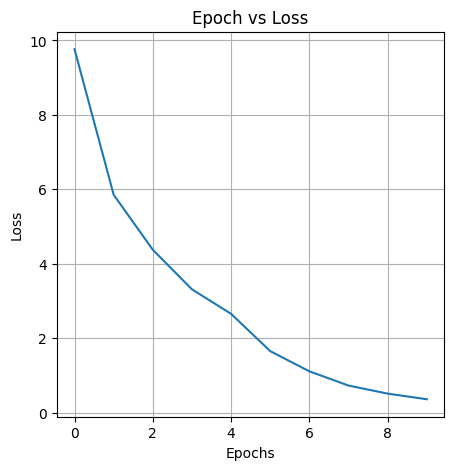

In [10]:
losses = history.history['loss']

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
ax1.plot(range(len(losses)),losses)

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Epoch vs Loss")
plt.grid()
plt.show()